Heart diseases prediction

EDA and data preprocessing

In [317]:
# Import libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc, RocCurveDisplay, make_scorer
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek

# Modelling libraries
import optuna
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# General settings 
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [350]:
# Getting dataset
data = pd.read_csv('framingham.csv')

In [351]:
# First look at the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [352]:
data.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [353]:
data.tail()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0
4239,0,39,3.0,1,30.0,0.0,0,0,0,196.0,133.0,86.0,20.91,85.0,80.0,0


In [354]:
data.sample(5)

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2081,1,48,3.0,1,25.0,0.0,0,0,0,200.0,126.5,91.5,30.34,75.0,NaN,0
447,1,46,4.0,1,45.0,0.0,0,0,0,209.0,112.5,65.0,27.48,75.0,78.0,0
4046,1,46,2.0,1,20.0,0.0,0,0,0,214.0,110.0,73.0,18.10,60.0,60.0,0
3054,0,57,2.0,1,20.0,1.0,0,1,0,315.0,193.0,109.0,27.99,70.0,74.0,0
3245,1,62,1.0,0,0.0,0.0,0,0,0,265.0,135.0,80.0,27.94,50.0,80.0,0


In [355]:
# Missing values analysis
data.isna().sum()

sex                  0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

We'll impute missing values with KNN imputer:


In [ ]:
# initializing KNNImputer
# knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# perform KNN imputation
# data_imputed = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)

In [176]:
# checking if after imputation categorical variables have only interger values - as they should have
# cat_imputed_columns = [col for col in ['education', 'BPMeds']]

# for var in cat_imputed_columns:
#     print(np.unique(data_imputed[var]))

# as we can see both variables have also float values - because of that we need to round those outcomes to the nearest integer

In [177]:
# defining columns to round
# columns_to_round = cat_imputed_columns

# rounding above columns to integers
# data_imputed[columns_to_round] = data_imputed[columns_to_round].round().astype(int)

In [178]:
# checking imputed variables once more
# cat_imputed_columns = [col for col in ['education', 'BPMeds']]

# for var in cat_imputed_columns:
#     print(np.unique(data_imputed[var]))
    
# everything is fine now :)

In [179]:
# comparison of datasets
# print('Original NaN values for dataset:')
# index_nan_mask = list(data[data.isna()].index)
# data[data.isna()]

In [180]:
# print('NaN values of original dataset after KNN imputation:')
# data_imputed[data_imputed.index.isin(index_nan_mask)]

In [181]:
data.dropna(axis=0, inplace=True)

In [182]:
data.isna().sum()

sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [183]:
data.shape

(3658, 16)

In [184]:
# Duplicate values
data.duplicated().sum()

0

In [185]:
data.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.443685,49.551941,1.980317,0.489065,9.025424,0.030344,0.005741,0.311646,0.027064,236.847731,132.370558,82.917031,25.782802,75.730727,81.852925,0.152269
std,0.496886,8.562029,1.022656,0.499949,11.921590,0.171557,0.075561,0.463229,0.162292,44.097681,22.086866,11.974258,4.065601,11.981525,23.904164,0.359331
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.875000,90.000000,28.037500,82.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [186]:
data.select_dtypes(include=['int64']).columns

Index(['sex', 'age', 'currentSmoker', 'prevalentStroke', 'prevalentHyp',
       'diabetes', 'TenYearCHD'],
      dtype='object')

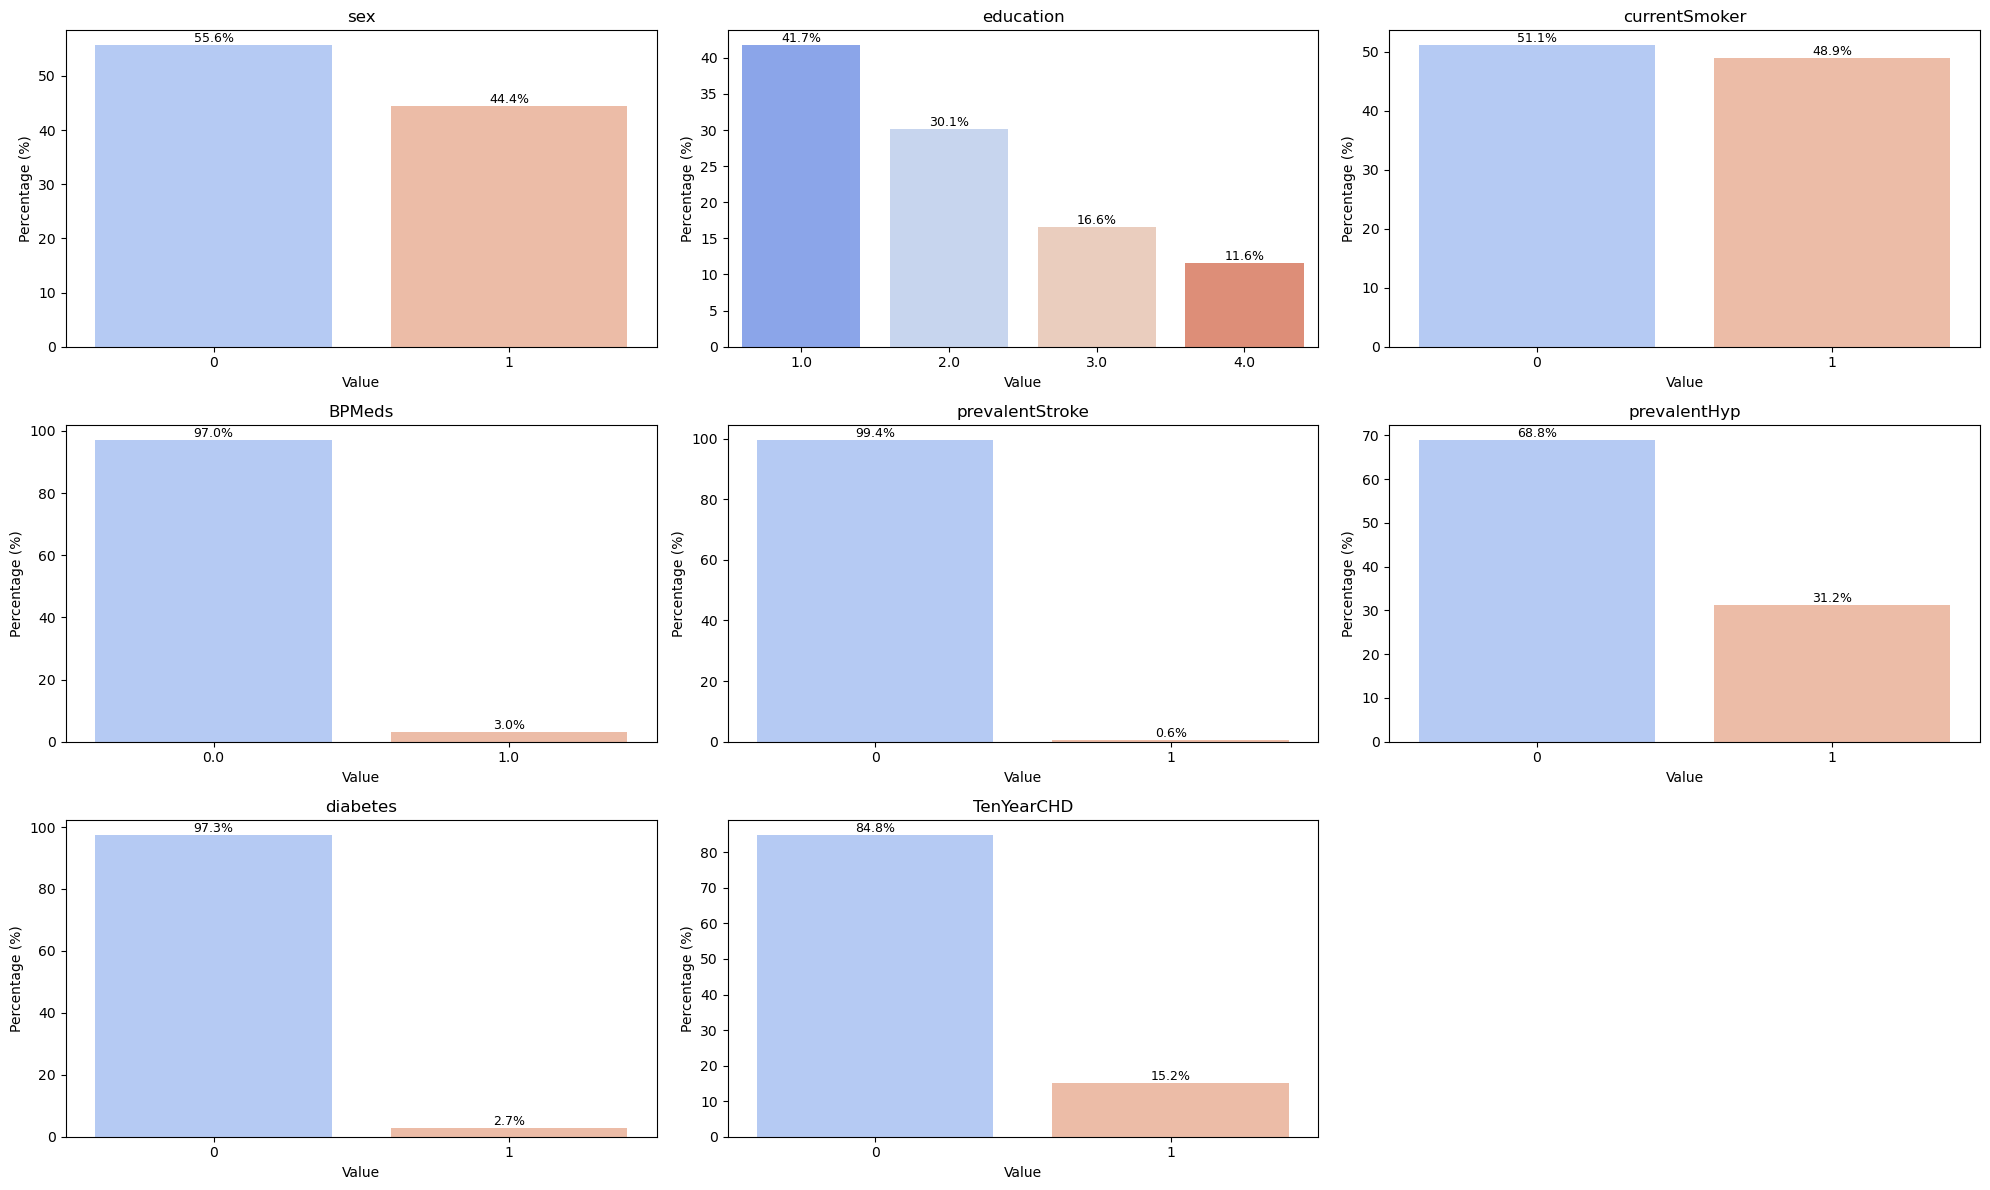

In [187]:
# % bar chart grid for each variable to examine outliers, error data values and feature distribution

# Intiger columns list 
cat_columns = [col for col in data.columns if col in ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']]

# Chart grid settings
n_cols = 3  
n_rows = int(np.ceil(len(cat_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Generating plots
for i, col in enumerate(cat_columns):
    # % for each value (0/1)
    percent_data = data[col].value_counts(normalize=True) * 100
    sns.barplot(
        x=percent_data.index,
        y=percent_data.values,
        ax=axes[i],
        palette="coolwarm",
    )
    # Labels
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("Value", fontsize=10)
    axes[i].set_ylabel("Percentage (%)", fontsize=10)
    for p in axes[i].patches:
        axes[i].annotate(f"{p.get_height():.1f}%", 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha="center", va="bottom", fontsize=9)

# Hide empty axes (if variables are less than n_rows * n_cols)
for j in range(len(cat_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

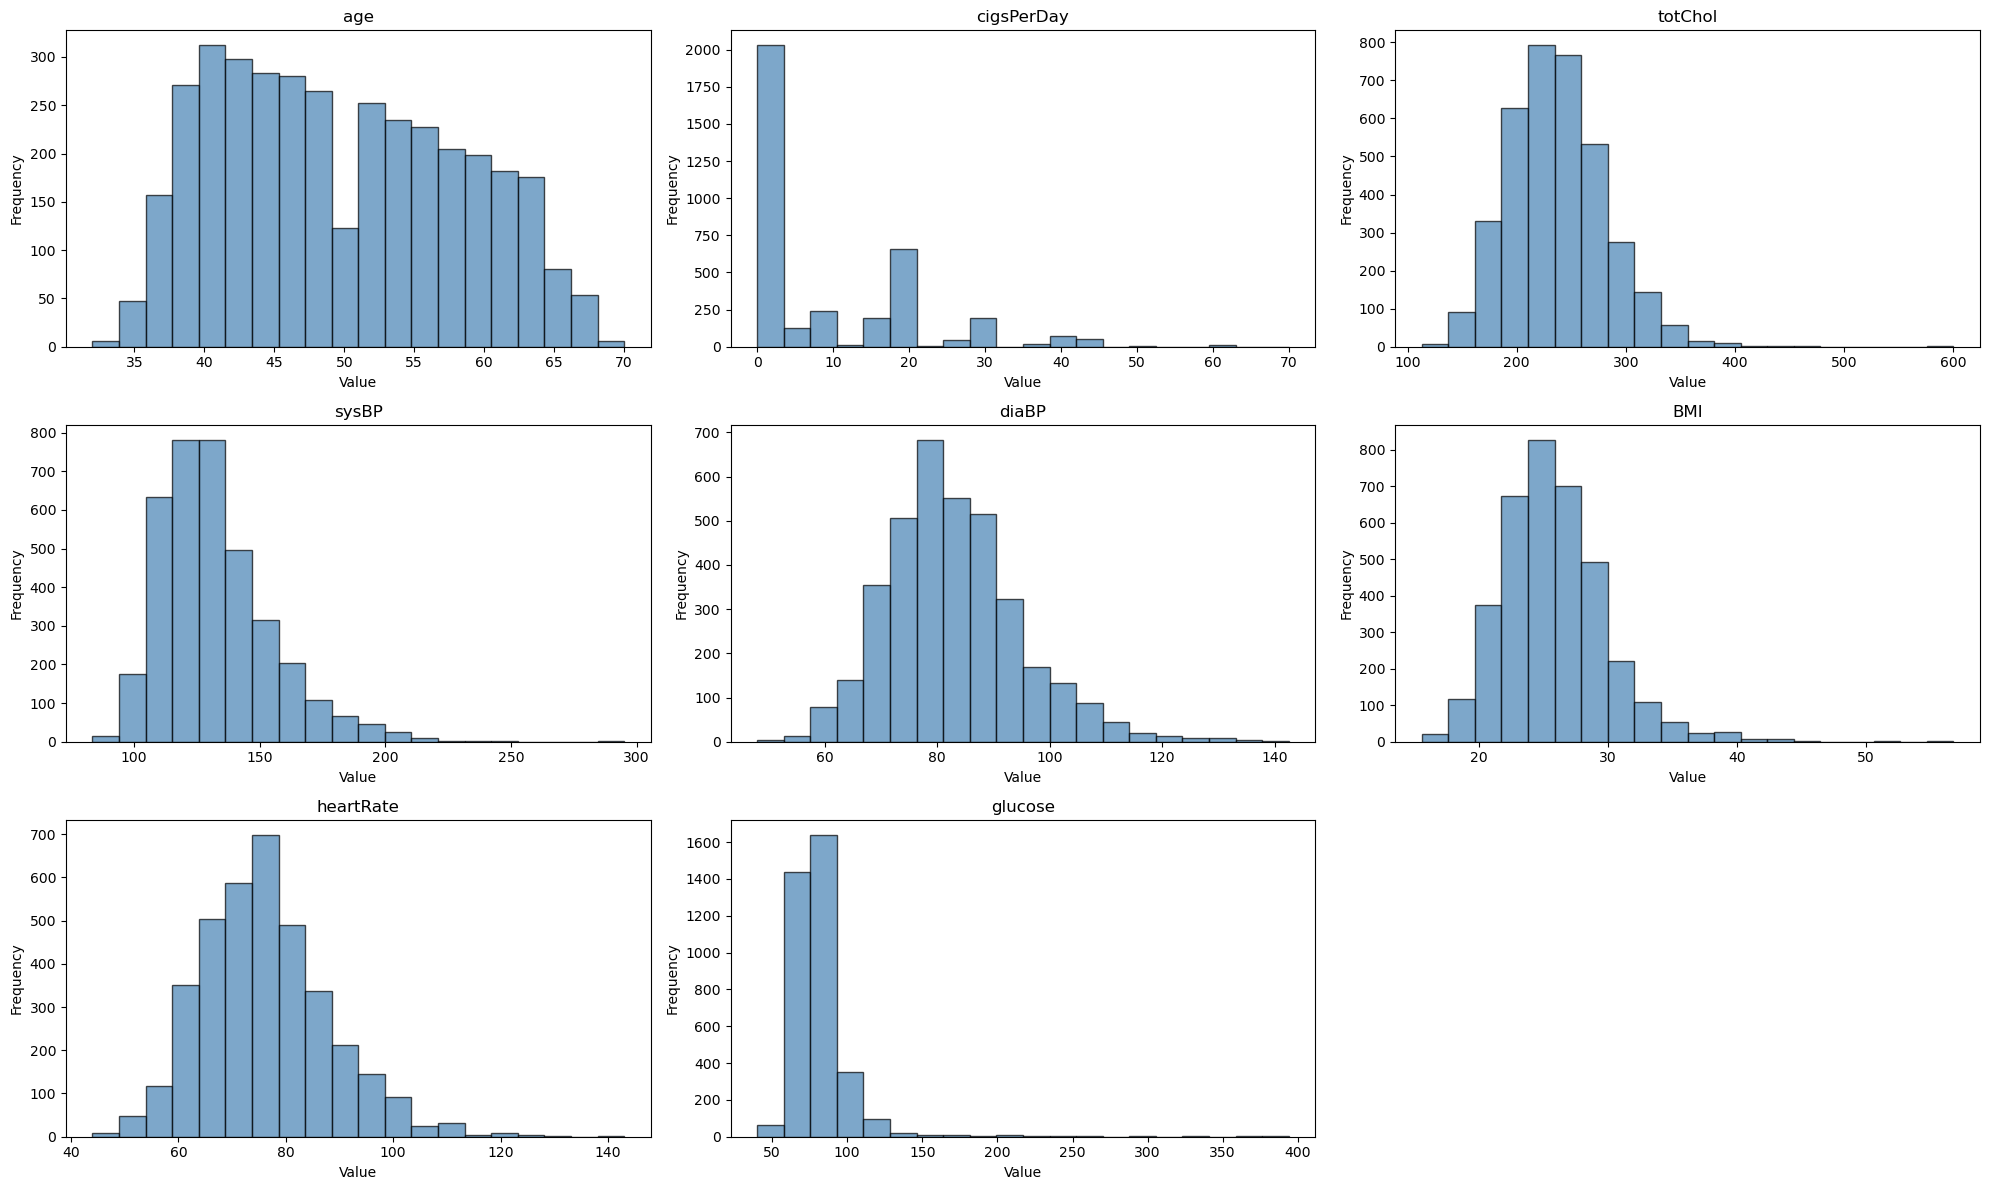

In [188]:
# List of columns
num_columns = [
    col for col in data.columns 
    if col in ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
]

# Chart grid settings
n_cols = 3  
n_rows = int(np.ceil(len(num_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Generating histograms
for i, col in enumerate(num_columns):
    axes[i].hist(data[col], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
    
    # Labels
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("Value", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)

# Hide empty axes (if variables are less than n_rows * n_cols)
for j in range(len(num_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [189]:
num_columns_df = data[['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]

cat_columns_df = data[['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']]

target_column_df = data['TenYearCHD']

In [190]:
# correlation matrix for numerical features
num_corr_matrix = num_columns_df.corr()

# lower and upper triangle masks 
num_upper_mask = np.triu(num_corr_matrix, k=1)
num_lower_mask = np.tril(num_corr_matrix, k=1)


# correlation matrix for categorical features
cat_corr_matrix = cat_columns_df.corr(method='spearman')

# lower and upper triangle masks 
cat_upper_mask = np.triu(cat_corr_matrix, k=1)
cat_lower_mask = np.tril(cat_corr_matrix, k=1)

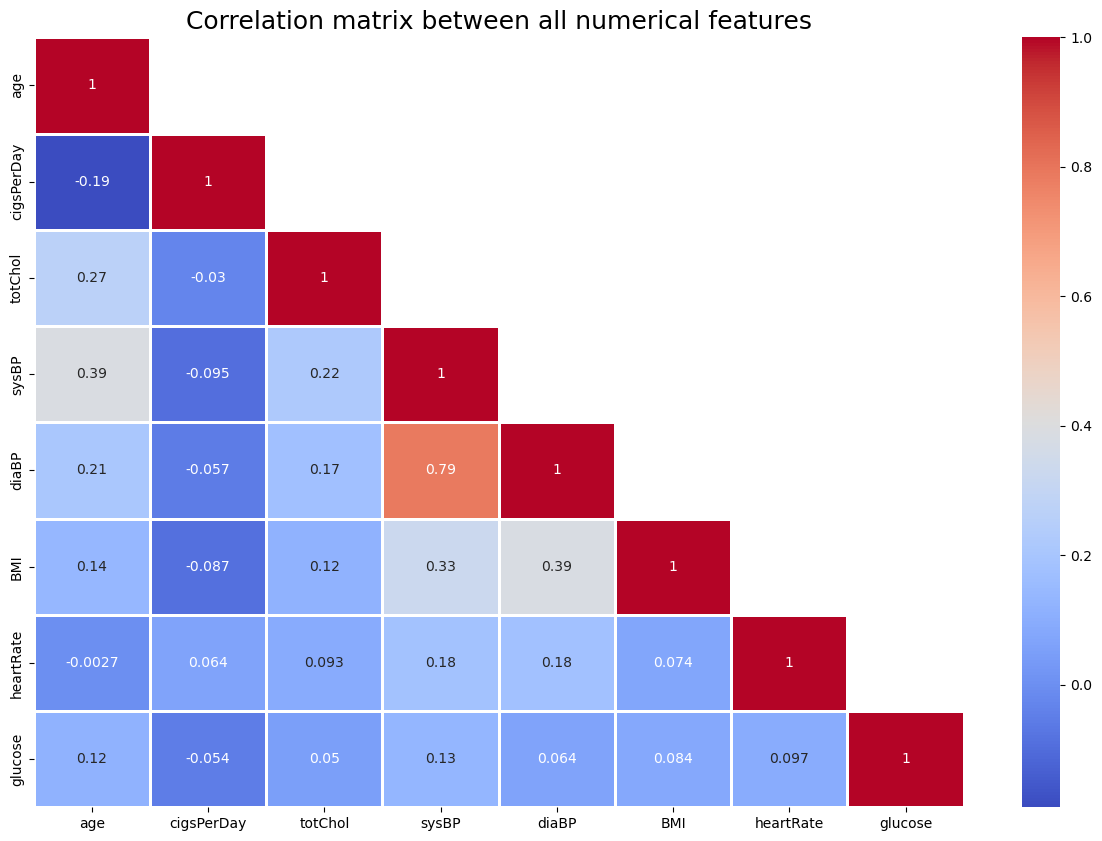

In [191]:
# linear correlation between features
plt.figure(figsize=(15,10))
sns.heatmap(num_columns_df.corr(), mask=num_upper_mask, cmap='coolwarm', linewidths=2, annot=True)
plt.title('Correlation matrix between all numerical features', fontsize=18)
plt.show()

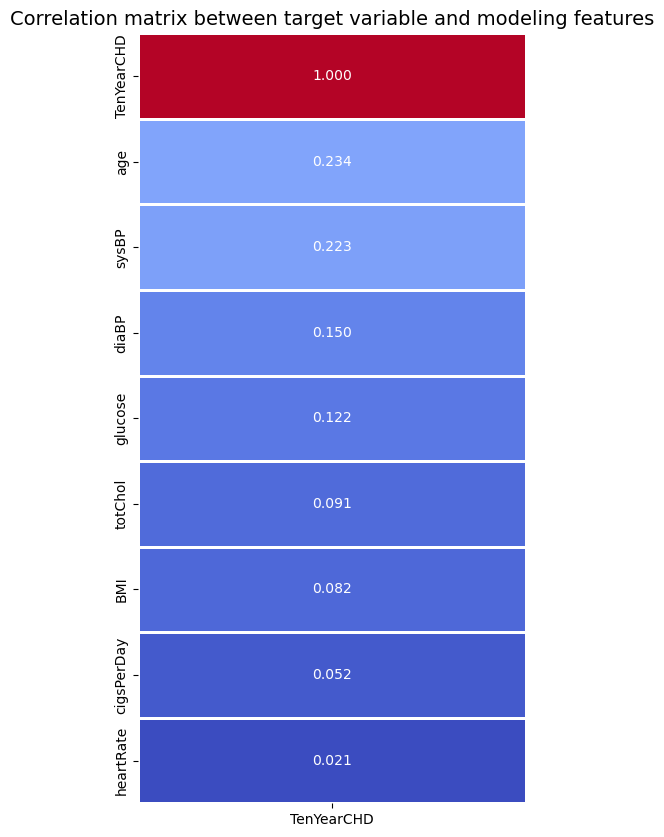

In [192]:
num_correlation_df = pd.concat([num_columns_df, target_column_df], axis=1)

correlation_matrix = num_correlation_df.corr()

TenYearCHD_correlation = correlation_matrix['TenYearCHD'].sort_values(ascending=False)

plt.figure(figsize=(5, 10))
sns.heatmap(TenYearCHD_correlation.to_frame(), annot=True, cmap='coolwarm', linewidths=2, cbar=False, fmt='.3f')
plt.title('Correlation matrix between target variable and modeling features', fontsize=14)
plt.show()

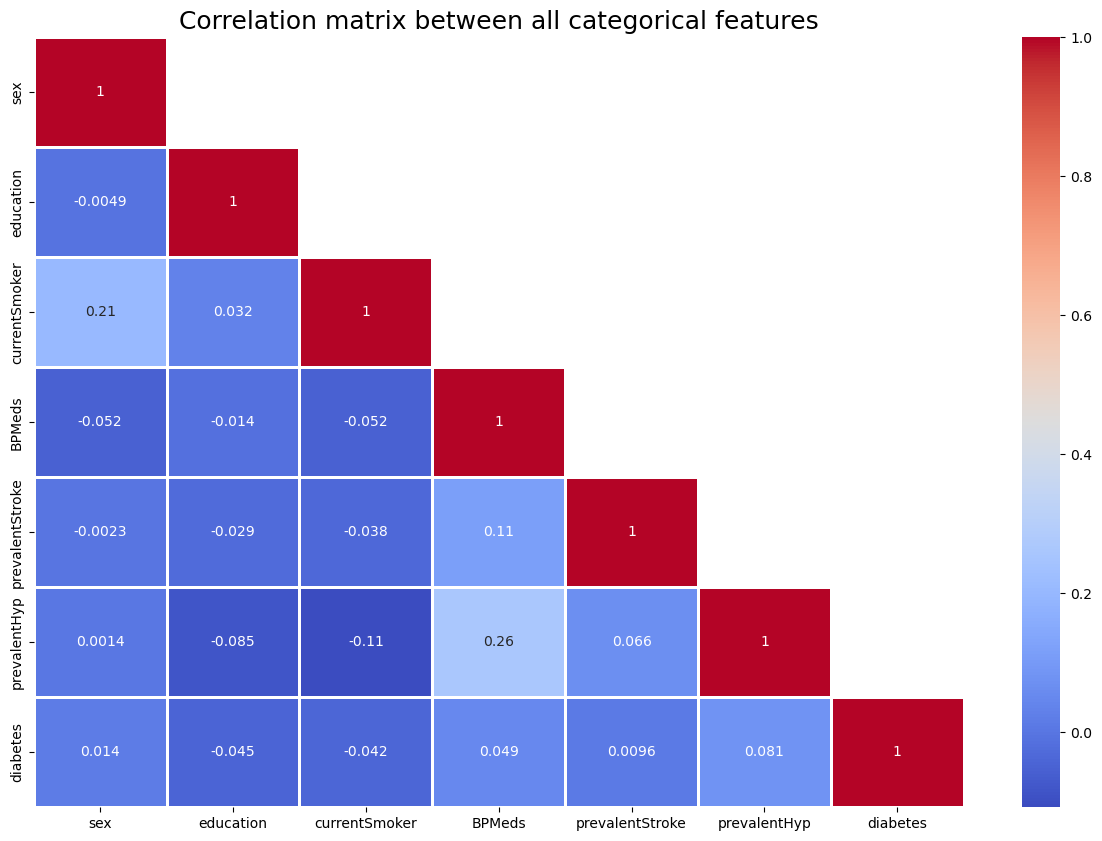

In [193]:
# correlation between categorical features
plt.figure(figsize=(15,10))
sns.heatmap(cat_columns_df.corr(method='spearman'), mask=cat_upper_mask, cmap='coolwarm', linewidths=2, annot=True)
plt.title('Correlation matrix between all categorical features', fontsize=18)
plt.show()

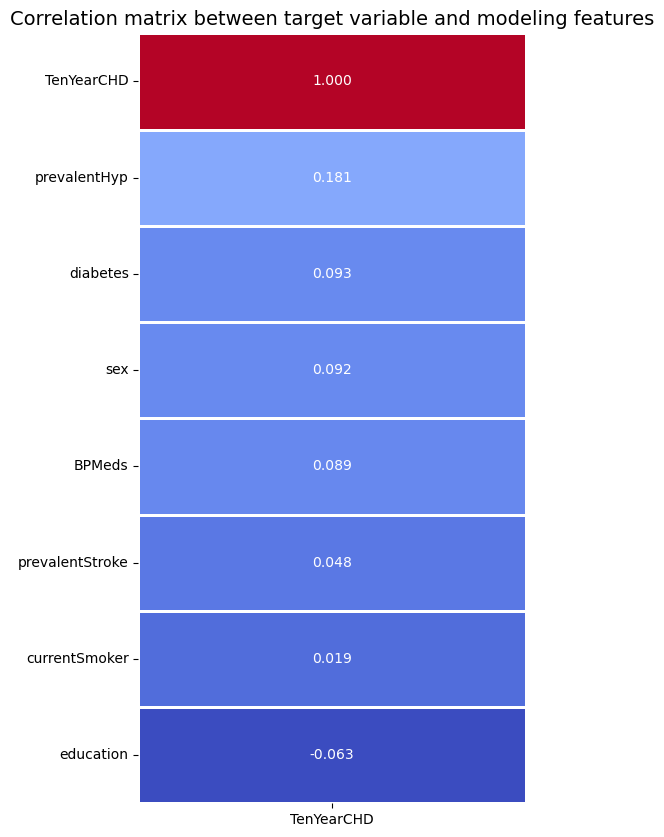

In [194]:
cat_correlation_df = pd.concat([cat_columns_df, target_column_df], axis=1)

correlation_matrix = cat_correlation_df.corr()

TenYearCHD_correlation = correlation_matrix['TenYearCHD'].sort_values(ascending=False)

plt.figure(figsize=(5, 10))
sns.heatmap(TenYearCHD_correlation.to_frame(), annot=True, cmap='coolwarm', linewidths=2, cbar=False, fmt='.3f')
plt.title('Correlation matrix between target variable and modeling features', fontsize=14)
plt.show()

In [195]:
# splitting edcuation variable with dummy variables
cat_df_dummies = pd.get_dummies(cat_columns_df, columns=['education'], prefix='education', prefix_sep='_')

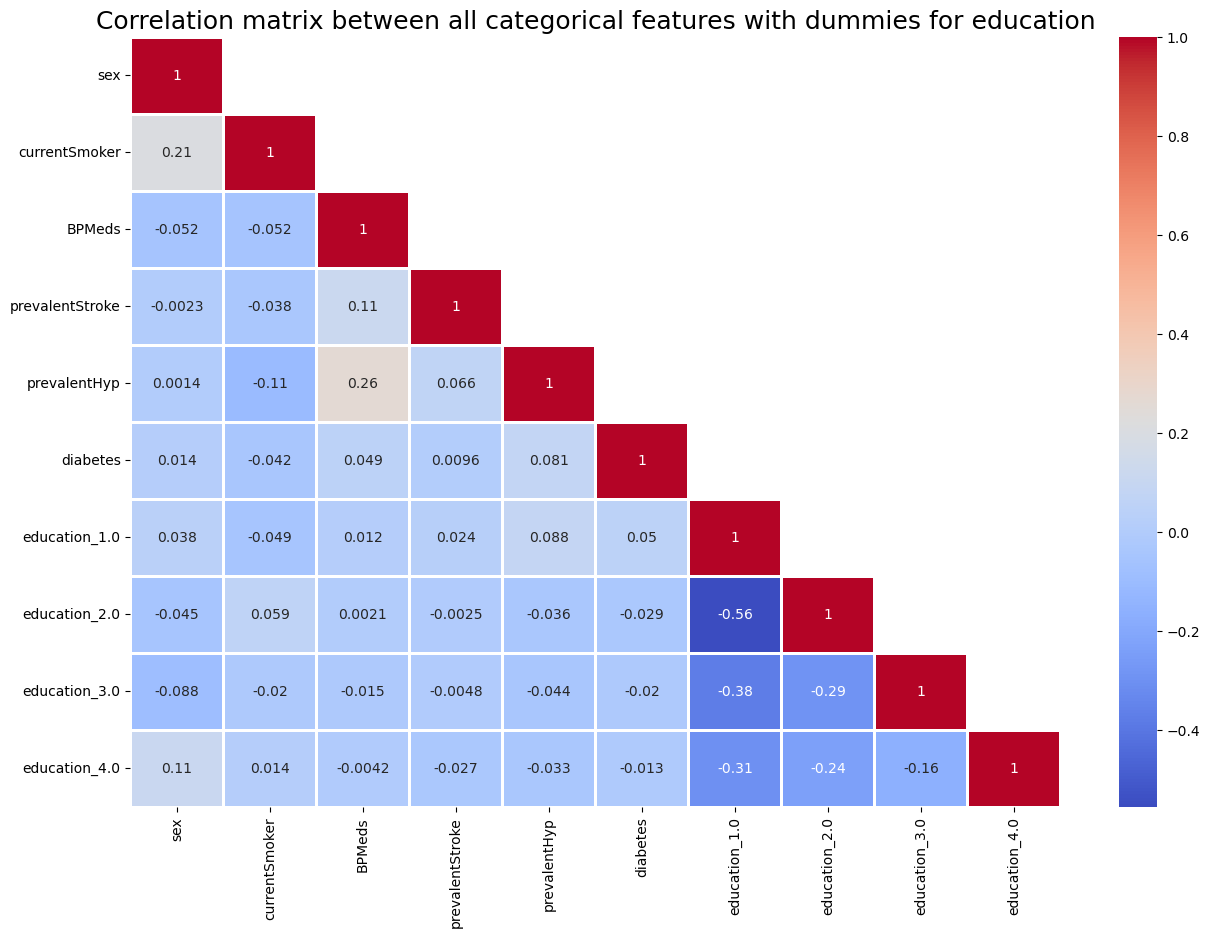

In [196]:
# correlation matrix for categorical features
cat_dummies_corr_matrix = cat_df_dummies.corr(method='spearman')

# lower and upper triangle masks 
cat_upper_mask = np.triu(cat_dummies_corr_matrix, k=1)
cat_lower_mask = np.tril(cat_dummies_corr_matrix, k=1)

# correlation between categorical features
plt.figure(figsize=(15,10))
sns.heatmap(cat_dummies_corr_matrix, mask=cat_upper_mask, cmap='coolwarm', linewidths=2, annot=True)
plt.title('Correlation matrix between all categorical features with dummies for education', fontsize=18)
plt.show()

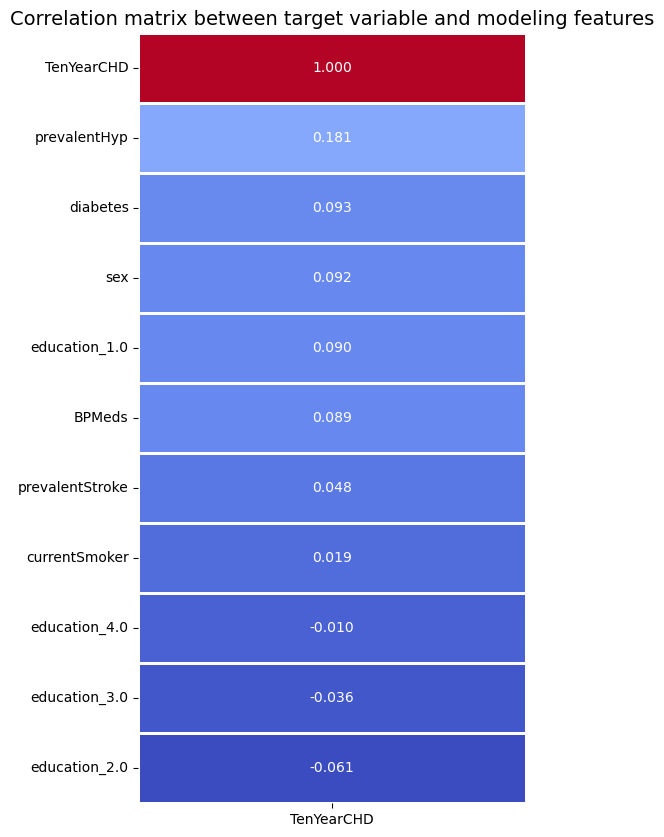

In [197]:
cat_correlation_df = pd.concat([cat_df_dummies, target_column_df], axis=1)

correlation_matrix = cat_correlation_df.corr()

TenYearCHD_correlation = correlation_matrix['TenYearCHD'].sort_values(ascending=False)

plt.figure(figsize=(5, 10))
sns.heatmap(TenYearCHD_correlation.to_frame(), annot=True, cmap='coolwarm', linewidths=2, cbar=False, fmt='.3f')
plt.title('Correlation matrix between target variable and modeling features', fontsize=14)
plt.show()

In [198]:
# keeping education splited into dummies
data = pd.get_dummies(data, columns=['education'], prefix='education', prefix_sep='_')
data

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,education_1.0,education_2.0,education_3.0,education_4.0
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,False,False,False,True
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,False,True,False,False
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,True,False,False,False
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,False,False,True,False
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1,True,False,False,False
4234,1,51,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0,False,False,True,False
4237,0,52,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0,False,True,False,False
4238,1,40,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0,False,False,True,False


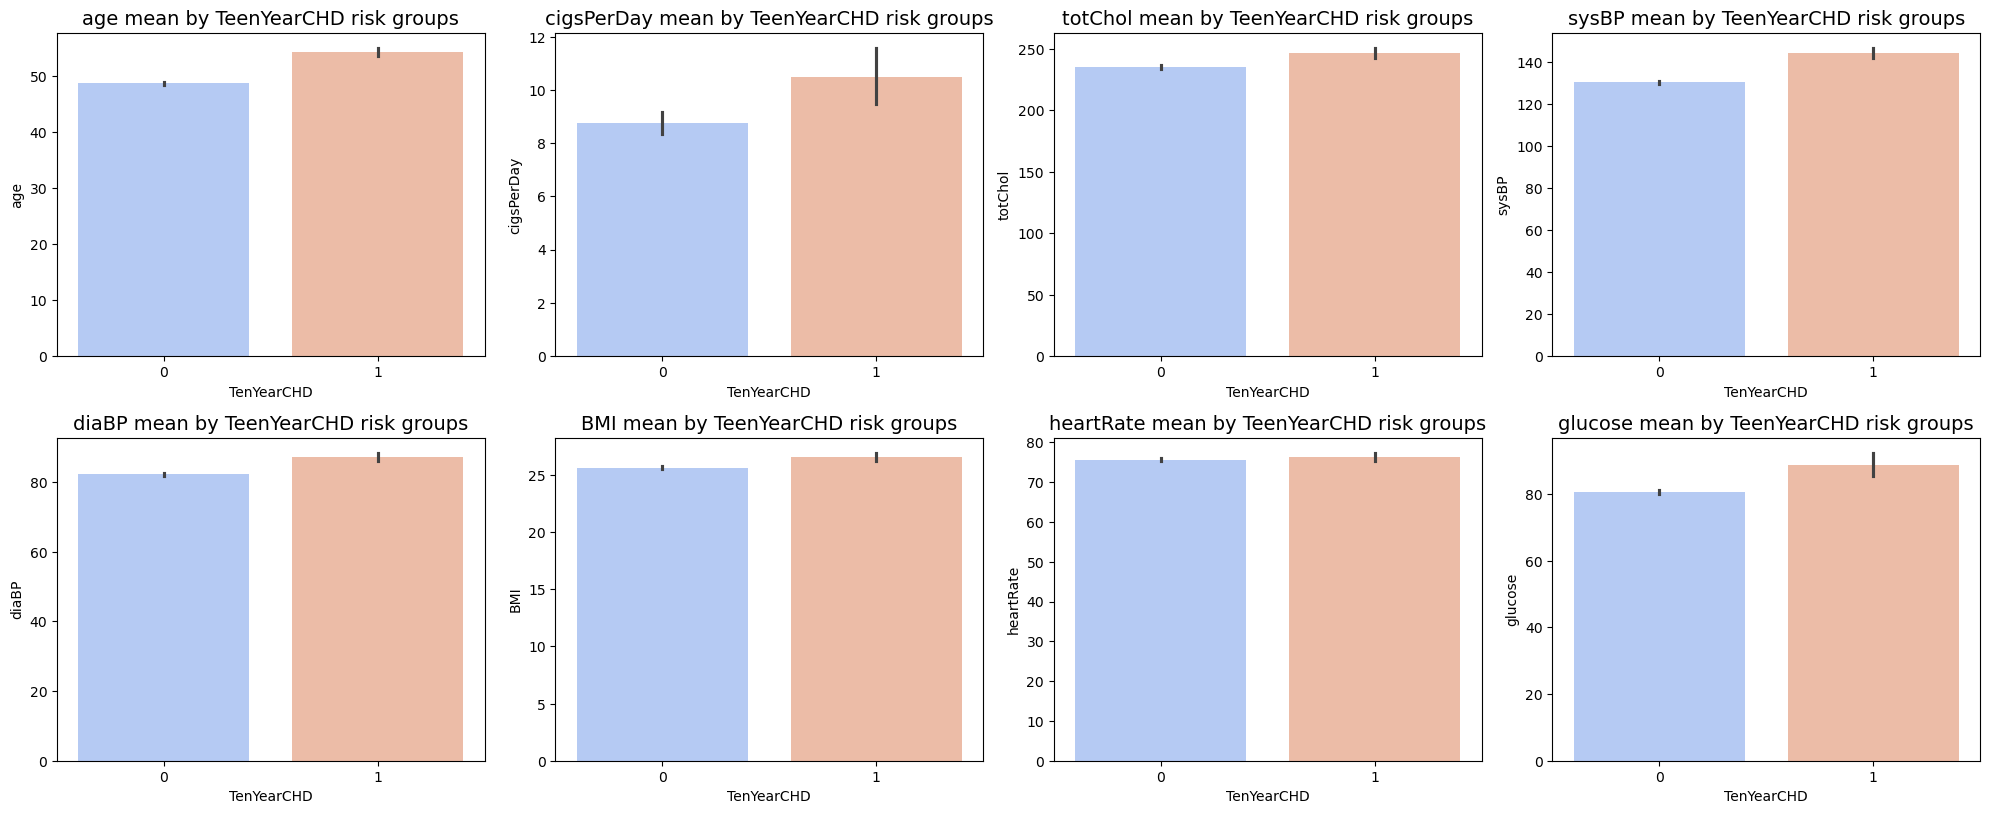

In [199]:
# Mean bar chart grid for each variable to examine differences between 10-year risk of coronary heart disease groups. The line in the bars indicates the 95% confidence interval
n_cols = 4 
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()  

for i, col in enumerate(num_columns):
    sns.barplot(
        x='TenYearCHD', 
        y=col, 
        data=data, 
        ax=axes[i], 
        palette='coolwarm',
        ci=95  
    )
    axes[i].set_title(f'{col} mean by TeenYearCHD risk groups', fontsize=14)
    axes[i].set_xlabel('TenYearCHD')
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

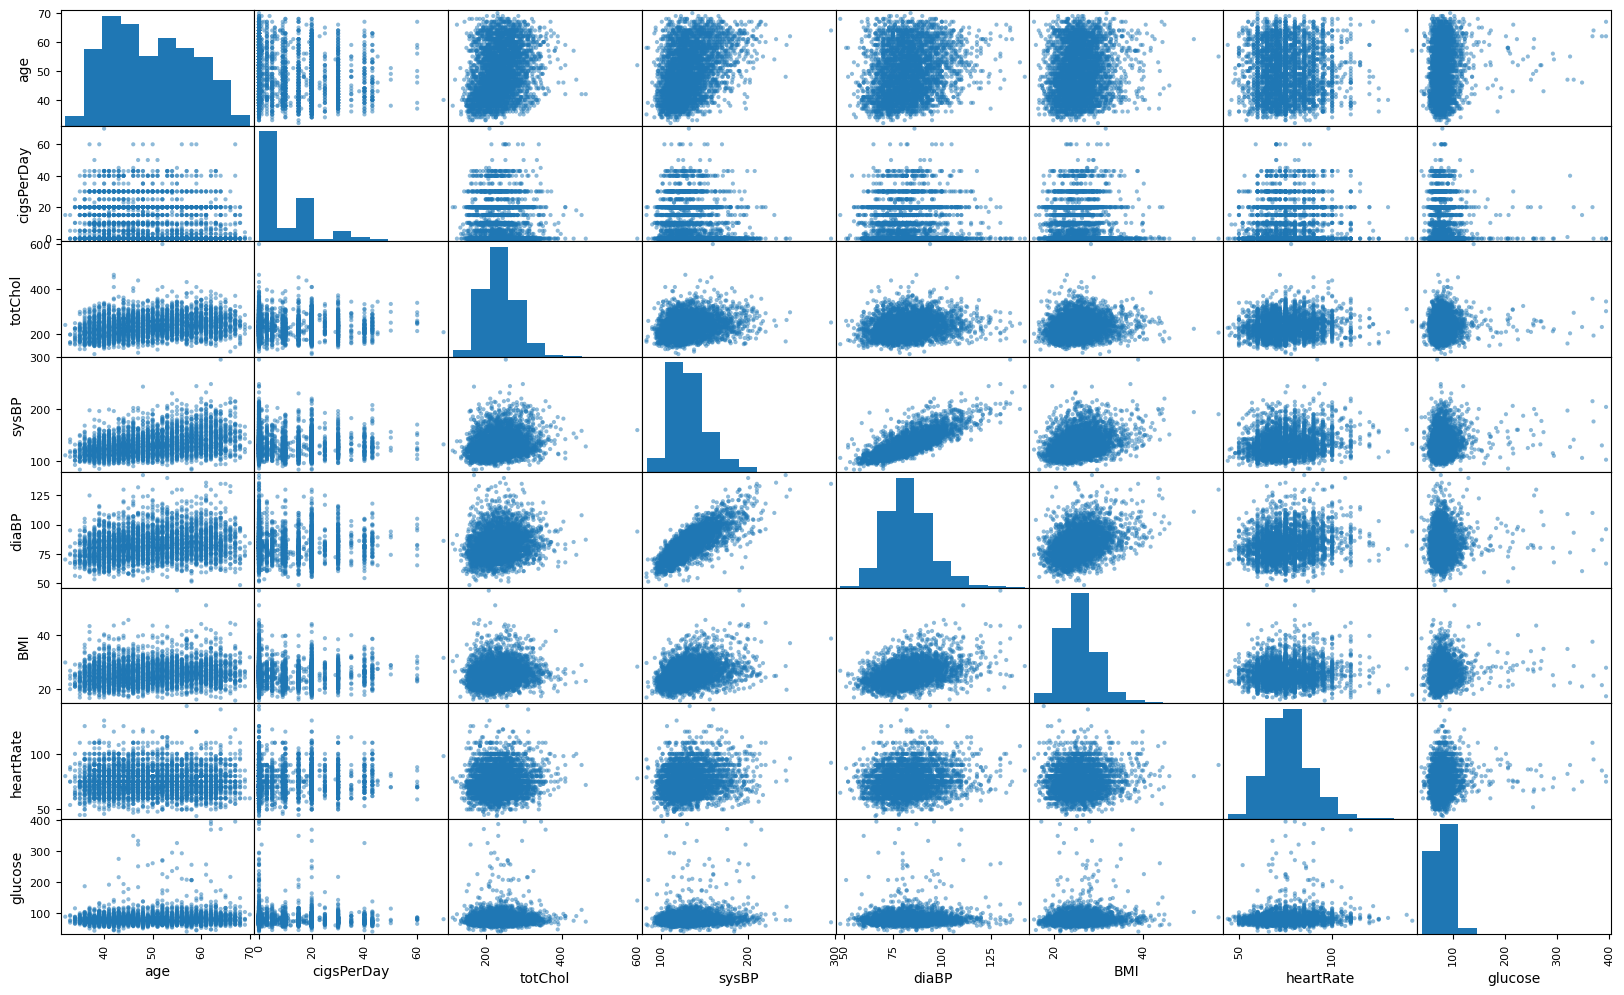

In [200]:
scatter_matrix(num_columns_df,figsize=(20,12))
plt.show()

Information Value of each column

In [201]:
# function to calculate Information Value and Weight of Evidence
# WoE = ln(Non_event_percentage/Event_percentage)
# IV = sigma(Event_percentage - Non_event_percentage) * WoE
# Event is probe when we have patient with one of our targeted diseases
# Non-event is probe when we have patient with one of our targeted diseases

def iv_calc(data, target, bins=10, woe_show=True):
    
    # Data frames to fill
    iv_df, woe_df = pd.DataFrame(), pd.DataFrame()
    
    # Independent variables list
    col_list = data.columns
    
    # WOE and IV calculation for each independent variable
    for col in col_list[~col_list.isin([target])]:
        if (data[col].dtype.kind in 'bifc') and (len(np.unique(data[col])) > 10):
            binned_x = pd.qcut(data[col], bins, duplicates='drop') # binned_x is to balance number of observation in each bin, so WoE wouldn't be biased
            d_temp = pd.DataFrame({'x': binned_x,
                                   'y': data[target]})
        else:
            d_temp = pd.DataFrame({'x': data[col],
                                   'y': data[target]})
            
        # Number of events in each group (bin)
        d = d_temp.groupby('x', as_index=False).agg({
            'y': ['count','sum']})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Percentage of events in each group (bin)
        d['Event_percentage'] = d['Events']/d['Events'].sum()
        
        # Non-events in each group (bin)
        d['Non_events'] = np.abs(d['N'] - d['Events'])
        # Non-events percentage in each group
        d['Non_event_percentage'] = d['Non_events']/d['Non_events'].sum()
        
        # WoE calculation 
        d['WoE'] = np.log(d['Event_percentage']/d['Non_event_percentage'])
        d['IV'] = d['WoE'] * (d['Event_percentage'] - d['Non_event_percentage'])
        d.insert(loc=0, column='Variable', value=col)
        tmp = pd.DataFrame({'Variable': [col],
                            'IV': [d['IV'].sum()]},
                            columns = ['Variable','IV'])
        iv_df = pd.concat([iv_df, tmp], axis=0)
        woe_df = pd.concat([woe_df, d], axis=0)
        
        # Whether to show WoE data frame
        if woe_show == True:
            print(woe_df)
    
    return iv_df, woe_df

In [202]:
# calculation of Information Value for variables in our dataset
iv_df = iv_calc(data=data, target='TenYearCHD', bins=10, woe_show=False)[0]
iv_df.sort_values(by='IV', ascending=False)

,Variable,IV
0,age,0.472370
0,sysBP,0.336415
0,prevalentHyp,0.234698
0,diaBP,0.195528
0,totChol,0.078902
0,sex,0.064688
0,BMI,0.064498
0,education_1.0,0.062409
0,diabetes,0.048841
0,glucose,0.048096


In [203]:
data.columns

Index(['sex', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD', 'education_1.0',
       'education_2.0', 'education_3.0', 'education_4.0'],
      dtype='object')

In [204]:
num_columns

['age',
 'cigsPerDay',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose']

In [205]:
# dropping diaBP strongly correlated with sysBP - sysBP is more strongly correlated with target variable
# dropping heartRate and cigsPerDay as well - very low correlation
# num_columns_mod = [var for var in num_columns if var not in ('diaBP','heartRate','cigsPerDay')]
# num_columns_mod


In [206]:
from sklearn.preprocessing import MinMaxScaler

# Skopiowanie danych - usunięcie mało znaczących zmiennych - education_4,education_3,education_2,currentSmoker,prevalentStroke
# scaled_data = data.loc[:,~data.columns.isin(['education_4','education_3','education_2','currentSmoker','prevalentStroke'])].copy()
scaled_data = data.copy()

# Inicjalizacja skalera
min_max_scaler = MinMaxScaler()

# Skalowanie tylko zmiennych numerycznych
scaled_data[num_columns] = min_max_scaler.fit_transform(data[num_columns])

# dropping heartRate as insignifficant variable
# scaled_data = scaled_data.drop(columns='heartRate')


In [235]:
signif_columns = ['age','sex','cigsPerDay','BPMeds','prevalentStroke','prevalentHyp','diabetes','totChol','sysBP','diaBP','BMI','heartRate','glucose','TenYearCHD']

In [236]:
scaled_data = scaled_data[signif_columns]

Feature scalling

In [238]:
scaled_data.head()

,age,sex,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0.184211,1,0.000000,0.0,0,0,0,0.168378,0.106383,0.232804,0.277024,0.363636,0.104520,0
1,0.368421,0,0.000000,0.0,0,0,0,0.281314,0.177305,0.349206,0.319680,0.515152,0.101695,0
2,0.421053,1,0.285714,0.0,0,0,0,0.271047,0.208038,0.338624,0.237518,0.313131,0.084746,0
3,0.763158,0,0.428571,0.0,0,1,0,0.229979,0.314421,0.497354,0.316045,0.212121,0.177966,1
4,0.368421,0,0.328571,0.0,0,0,0,0.353183,0.219858,0.380952,0.183228,0.414141,0.127119,0


In [239]:
scaled_data['TenYearCHD'].value_counts()

TenYearCHD
0    3101
1     557
Name: count, dtype: int64

Classification model based on Logistic Regression

In [297]:
# Splitting the data into features (X) and target variable (y)
X = scaled_data.drop('TenYearCHD', axis=1)
y = scaled_data['TenYearCHD']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# resampling of X_train and y_train with SMOTE
smote = SMOTETomek(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79       931
           1       0.27      0.63      0.38       167

    accuracy                           0.68      1098
   macro avg       0.59      0.66      0.58      1098
weighted avg       0.82      0.68      0.73      1098

AUC Score: 0.721


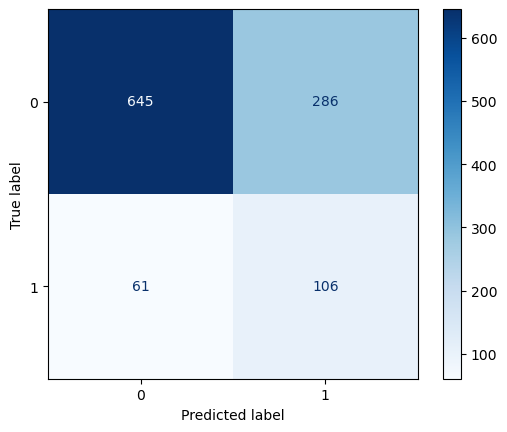

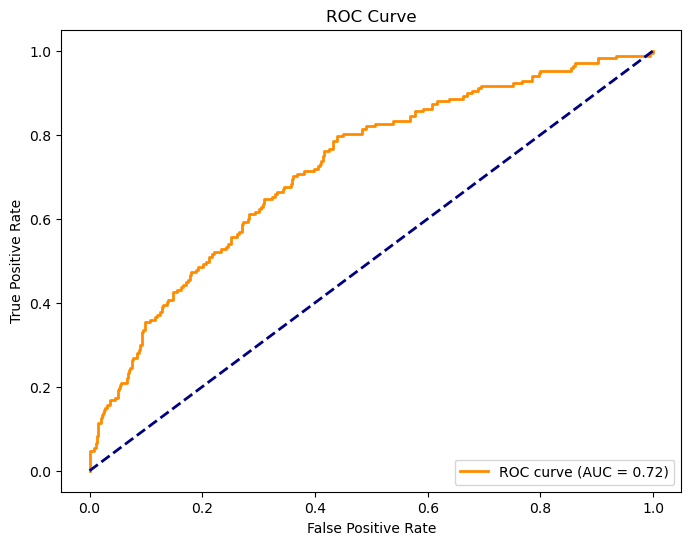


Feature Importance:
            Feature  Importance
0               age    0.889875
5      prevalentHyp    0.580175
1               sex    0.367713
8             sysBP    0.298295
9             diaBP    0.228623
2        cigsPerDay    0.154903
6          diabetes    0.147915
7           totChol    0.139936
3            BPMeds    0.122396
12          glucose    0.122244
10              BMI    0.103067
4   prevalentStroke   -0.002253
11        heartRate   -0.010415

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
2579       0          0     0.451025
3726       0          1     0.561410
2182       0          0     0.423552
4          0          0     0.371079
536        0          0     0.410369
6          1          0     0.451180
2746       1          0     0.348931
1703       0          1     0.555876
978        1          1     0.669036
2592       0          0     0.297213


In [298]:
# Logistic regression model
lr_model = LogisticRegression(random_state=42, class_weight='balanced', penalty='l2', C=0.01)
lr_model.fit(X_train_resampled, y_train_resampled)

# Predictions and probability predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap='Blues')

# calculation of AUC score
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
auc_score = roc_auc_score(y_test, y_pred_proba_lr)

print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# feature importance (model coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lr_model.coef_[0]
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_lr,
    'Probability': y_pred_prob_lr
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))


In [299]:
# calibration Logistic Regression model
lr_calibrated = CalibratedClassifierCV(lr_model, method='sigmoid', cv='prefit')  # Sigmoid scaling
lr_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=0.01,
                                                    class_weight='balanced',
                                                    random_state=42))

In [300]:
# search for optimun parameters using gridsearch
params= {'n_neighbors': np.arange(1, 5)}
grid_search = GridSearchCV(estimator = KNeighborsClassifier(), 
                           param_grid = params,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)

knn_model = GridSearchCV(KNeighborsClassifier(),
                         params,
                         cv=5,
                         n_jobs=-1)

# train the model
knn_model.fit(X_train_resampled,y_train_resampled)
knn_model.best_params_

# predictions
y_pred_knn = knn_model.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       931
           1       0.23      0.26      0.24       167

    accuracy                           0.76      1098
   macro avg       0.55      0.55      0.55      1098
weighted avg       0.77      0.76      0.76      1098

AUC Score: 0.572


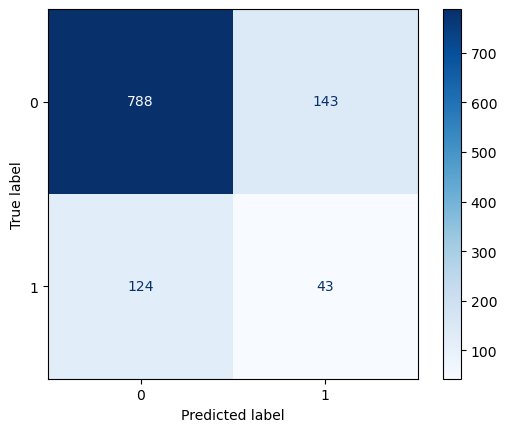

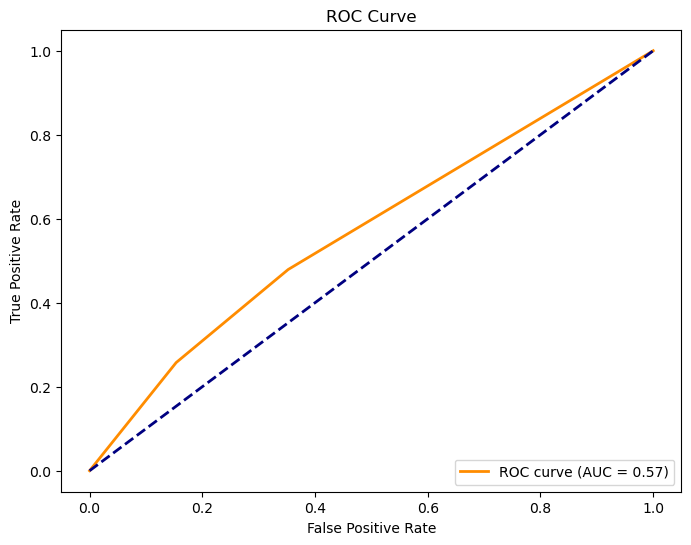


Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
2579       0          0          0.5
3726       0          0          0.5
2182       0          0          0.0
4          0          0          0.0
536        0          0          0.0
6          1          0          0.0
2746       1          0          0.0
1703       0          0          0.5
978        1          0          0.0
2592       0          0          0.0


In [301]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Blues')

# calculation of AUC score
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
auc_score = roc_auc_score(y_test, y_pred_proba_knn)

print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_knn,
    'Probability': y_pred_proba_knn
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))


In [302]:
# calibration Logistic Regression model
knn_calibrated = CalibratedClassifierCV(knn_model, method='sigmoid', cv='prefit')  # Sigmoid scaling
knn_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=GridSearchCV(cv=5,
                                              estimator=KNeighborsClassifier(),
                                              n_jobs=-1,
                                              param_grid={'n_neighbors': array([1, 2, 3, 4])}))

In [303]:
# Random Forest optimization with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000), # number of trees in the forest
        'max_depth': trial.suggest_int('max_depth', 10, 50), # maximum depth of tree
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), # minimum samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20), # minimum samples at a leaf node
        'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']), # maximum features to consider for splitting
        'class_weight': 'balanced'
        }

    model = RandomForestClassifier(
        **params,
        random_state=42,
        verbose=False
        )
        
    scores = cross_val_score(
        model,
        X_train_resampled,
        y_train_resampled,
        cv=5,
        scoring='roc_auc'
        )

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best hyperparameters for model Random Forest Classifier: {study.best_params}")

# Train final model with the best hyperparameters
rf_model = RandomForestClassifier(
    **study.best_params,
    random_state=42
    )

rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class


[I 2025-01-22 01:29:05,159] A new study created in memory with name: no-name-c5123f10-8b78-4eed-bc73-cd78c5d231be
[I 2025-01-22 01:29:24,255] Trial 0 finished with value: 0.8755512054981441 and parameters: {'n_estimators': 855, 'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.8755512054981441.
[I 2025-01-22 01:29:33,750] Trial 1 finished with value: 0.9402768912747952 and parameters: {'n_estimators': 358, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9402768912747952.
[I 2025-01-22 01:29:42,243] Trial 2 finished with value: 0.8809174303147577 and parameters: {'n_estimators': 387, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 1 with value: 0.9402768912747952.
[I 2025-01-22 01:29:57,023] Trial 3 finished with value: 0.9269307093320108 and parameters: {'n_estimators': 586, 'max_depth': 45, 

Best hyperparameters for model Random Forest Classifier: {'n_estimators': 385, 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       931
           1       0.34      0.34      0.34       167

    accuracy                           0.80      1098
   macro avg       0.61      0.61      0.61      1098
weighted avg       0.80      0.80      0.80      1098

AUC Score: 0.702


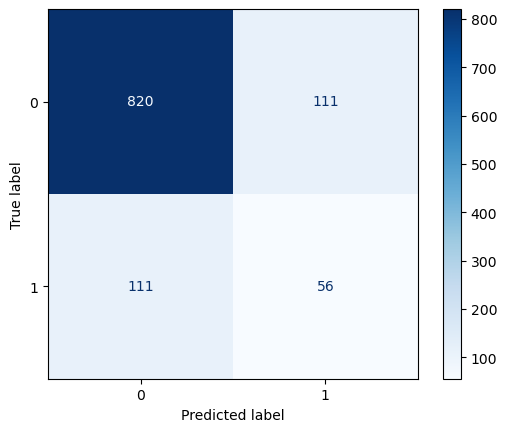

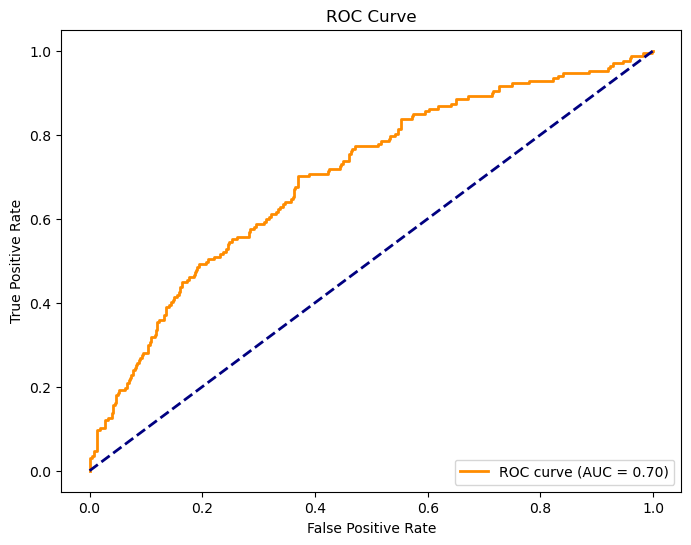


Feature Importance:
            Feature  Importance
0               age    0.194613
8             sysBP    0.139027
11        heartRate    0.113698
9             diaBP    0.108786
7           totChol    0.106359
12          glucose    0.100472
10              BMI    0.099576
2        cigsPerDay    0.073478
5      prevalentHyp    0.028647
1               sex    0.026051
3            BPMeds    0.005023
6          diabetes    0.003754
4   prevalentStroke    0.000516

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
2579       0          0     0.299207
3726       0          1     0.567196
2182       0          0     0.187133
4          0          0     0.228010
536        0          0     0.119530
6          1          0     0.254705
2746       1          0     0.222411
1703       0          0     0.310420
978        1          0     0.322590
2592       0          0     0.102736


In [304]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')

# calculation of AUC score
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
auc_score = roc_auc_score(y_test, y_pred_proba_rf)

print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# feature importance (model coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Probability': y_pred_proba_rf
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))


In [305]:
# calibration of Random Forest model
rf_calibrated = CalibratedClassifierCV(rf_model, method='isotonic', cv='prefit')
rf_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(max_depth=36,
                                                        min_samples_leaf=2,
                                                        min_samples_split=4,
                                                        n_estimators=385,
                                                        random_state=42),
                       method='isotonic')

In [311]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0.0000000001, 10, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0)
    }

    model = CatBoostClassifier(
        **params,
        random_state=42,
        eval_metric='AUC',
        verbose=False
    )

    scores = cross_val_score(
        model,
        X_train_resampled,
        y_train_resampled,
        cv=5,
        scoring='roc_auc',  # ROC AUC as evaluation metric
        n_jobs=-1
    )
    return scores.mean()

# Create and optimize the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters for CatBoost
print(f"Best hyperparameters for CatBoost: {study.best_params}")

# Train the final model with the best hyperparameters
xgb_model = CatBoostClassifier(
    **study.best_params,
    random_state=42,
    eval_metric='AUC',
    verbose=False
)

# Fit the final model on the entire training set
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Print the evaluation results (e.g., ROC AUC score on test set)
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"Test ROC AUC: {roc_auc}")

[I 2025-01-22 01:38:28,979] A new study created in memory with name: no-name-0a8a51f8-f988-49ae-8df4-9ac9e618fddd
[I 2025-01-22 01:38:30,630] Trial 0 finished with value: 0.9396384538831478 and parameters: {'iterations': 545, 'depth': 4, 'learning_rate': 0.20695079628573212, 'l2_leaf_reg': 3.0097957292605013, 'border_count': 68, 'bagging_temperature': 0.5018412712048386, 'random_strength': 0.029030182733434908, 'scale_pos_weight': 10.824325648005349}. Best is trial 0 with value: 0.9396384538831478.
[I 2025-01-22 01:38:36,306] Trial 1 finished with value: 0.921624597052582 and parameters: {'iterations': 765, 'depth': 8, 'learning_rate': 0.02063830900041305, 'l2_leaf_reg': 4.115751054113725, 'border_count': 116, 'bagging_temperature': 0.720609281233766, 'random_strength': 4.06122760748866, 'scale_pos_weight': 9.721725495012278}. Best is trial 0 with value: 0.9396384538831478.
[I 2025-01-22 01:38:39,295] Trial 2 finished with value: 0.9523259734413546 and parameters: {'iterations': 591, '

Best hyperparameters for CatBoost: {'iterations': 354, 'depth': 10, 'learning_rate': 0.15969925398375545, 'l2_leaf_reg': 1.0180894913570935, 'border_count': 78, 'bagging_temperature': 0.7529108665472706, 'random_strength': 3.3723559035114032, 'scale_pos_weight': 1.4898107315811937}
Test ROC AUC: 0.6775535931359623



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       931
           1       0.31      0.23      0.27       167

    accuracy                           0.80      1098
   macro avg       0.59      0.57      0.58      1098
weighted avg       0.78      0.80      0.79      1098

AUC Score: 0.678


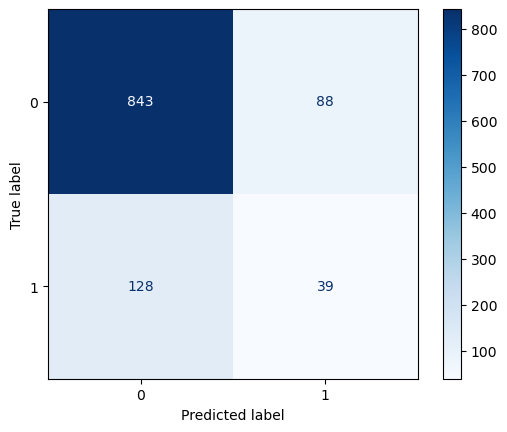

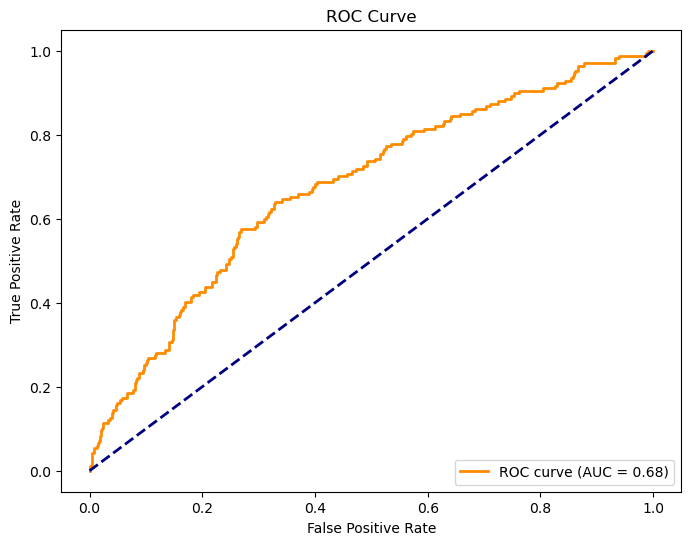


Feature Importance:
            Feature  Importance
11        heartRate   14.757107
0               age   14.495094
7           totChol   11.188806
12          glucose   11.041800
2        cigsPerDay   10.540340
10              BMI   10.172968
9             diaBP    9.530345
8             sysBP    8.566029
1               sex    5.712291
5      prevalentHyp    2.842551
3            BPMeds    0.688362
6          diabetes    0.402202
4   prevalentStroke    0.062104

Probability Predictions (example of 10 cases):
      Actual  Predicted  Probability
2579       0          0     0.002222
3726       0          1     0.711052
2182       0          0     0.014596
4          0          0     0.002159
536        0          0     0.004397
6          1          0     0.017354
2746       1          0     0.201772
1703       0          0     0.097816
978        1          0     0.090617
2592       0          0     0.003690


In [312]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# 1. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Blues')

# calculation of AUC score
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
auc_score = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"AUC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# feature importance (model coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# probability predictions
predictions_with_probabilities = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb,
    'Probability': y_pred_proba_xgb
})
print("\nProbability Predictions (example of 10 cases):")
print(predictions_with_probabilities.head(10))

In [314]:
# calibration of Random Forest model
xgb_calibrated = CalibratedClassifierCV(xgb_model, method='isotonic', cv='prefit')
xgb_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=<catboost.core.CatBoostClassifier object at 0x000001FD7608E600>,
                       method='isotonic')

In [315]:
# Function to plot calibration curve
def plot_calibration_curve(y_true, model, model_name):
    prob_true, prob_pred = calibration_curve(y_true, model.predict_proba(X_test)[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label=f'{model_name}')

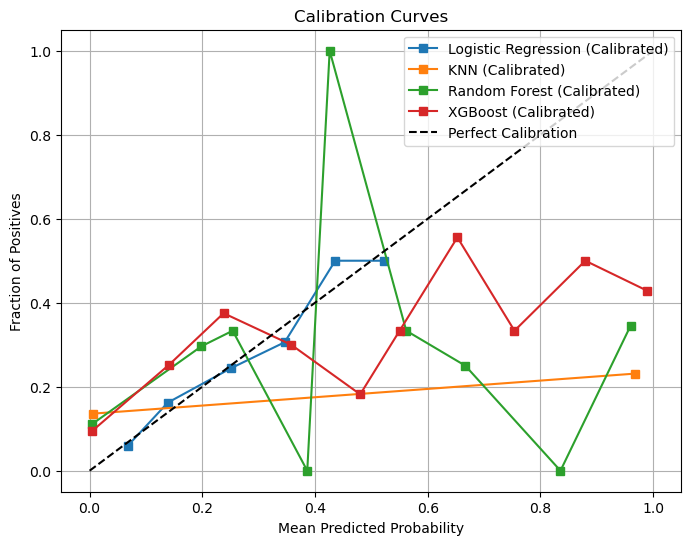

In [316]:
# Plotting calibration curves
plt.figure(figsize=(8, 6))
plot_calibration_curve(y_test, lr_calibrated, "Logistic Regression (Calibrated)")
plot_calibration_curve(y_test, knn_calibrated, "KNN (Calibrated)")
plot_calibration_curve(y_test, rf_calibrated, "Random Forest (Calibrated)")
plot_calibration_curve(y_test, xgb_calibrated, "XGBoost (Calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend(loc="best")
plt.grid()
plt.show()